In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/IEEE-CIS/

/content/drive/.shortcut-targets-by-id/1BUDjtdkbYP6ayadYsrcyHHHfPTJigLdc/IEEE-CIS


In [3]:
!ls

fpr_hist.npy	  __pycache__		tpr_logistic.npy  train_identity.csv
fpr_logistic.npy  test_df.csv		tpr_rf.npy	  train_transaction.csv
fpr_rf.npy	  test_transaction.csv	tpr_xgb.npy	  util_data_cleaning.py
fpr_xgb.npy	  tpr_hist.npy		train_df.csv	  util_reporting.py


In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# load provided datasets
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')

# combine datasets as needed
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [6]:
# Get useful features

# The dataset are sparse, only consider the features with less than 30% missing data
valid_cols = pd.DataFrame(train.isnull().sum()/len(train)*100 < 30)
valid_cols = valid_cols[valid_cols[0] == True]
train = train[list(valid_cols.index)]

y = train['isFraud']
X = train.drop(columns=['isFraud'])

In [7]:
categorical_features = {'ProductCD': 'category',
                   'card1': 'category','card2': 'category','card3': 'category','card4': 'category','card5': 'category','card6': 'category',
                   'addr1': 'category','addr2': 'category',
                   'P_emaildomain': 'category',
                   'M6': 'category'}
categorical_features = list(categorical_features.keys())
continuous_features = list(filter(lambda x: x not in categorical_features, X))

In [8]:
# Reference: https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
class ContinuousFeatureConverter:
    def __init__(self, name, feature, log_transform):
        self.name = name
        self.skew = feature.skew()
        self.log_transform = log_transform
        
    def transform(self, feature):
        if self.skew > 1:
            feature = self.log_transform(feature)
        
        mean = feature.mean()
        std = feature.std()
        return (feature - mean)/(std + 1e-6)        


In [9]:
# Reference: https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
from tqdm.autonotebook import tqdm
import numpy as np

feature_converters = {}
continuous_features_processed = []
continuous_features_processed_test = []

for f in tqdm(continuous_features):
    feature = X[f]
    log = lambda x: np.log10(x + 1 - min(0, x.min()))
    converter = ContinuousFeatureConverter(f, feature, log)
    feature_converters[f] = converter
    continuous_features_processed.append(converter.transform(feature))
    
continuous_train = pd.DataFrame({s.name: s for s in continuous_features_processed}).astype(np.float32)

<ipython-input-9-1f905bb7cbd5>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/190 [00:00<?, ?it/s]

In [10]:
continuous_train['isna_sum'] = continuous_train.isna().sum(axis=1)

continuous_train['isna_sum'] = (continuous_train['isna_sum'] - continuous_train['isna_sum'].mean())/continuous_train['isna_sum'].std()


In [11]:
# Reference: https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
isna_columns = []
for column in tqdm(continuous_features):
    isna = continuous_train[column].isna()
    if isna.mean() > 0.:
        continuous_train[column + '_isna'] = isna.astype(int)
        isna_columns.append(column)
        
continuous_train = continuous_train.fillna(0.)


  0%|          | 0/190 [00:00<?, ?it/s]

<ipython-input-11-db2b5e10a346>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  continuous_train[column + '_isna'] = isna.astype(int)
<ipython-input-11-db2b5e10a346>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  continuous_train[column + '_isna'] = isna.astype(int)
<ipython-input-11-db2b5e10a346>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

In [12]:
# Reference: https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm.autonotebook import tqdm

def categorical_encode(df_train, categorical_features, n_values=50):
    df_train = df_train[categorical_features].astype(str)
    
    categories = []
    for column in tqdm(categorical_features):
        categories.append(list(df_train[column].value_counts().iloc[: n_values - 1].index) + ['Other'])
        values2use = categories[-1]
        df_train[column] = df_train[column].apply(lambda x: x if x in values2use else 'Other')
        
    
    ohe = OneHotEncoder(categories=categories)
    ohe.fit(df_train)
    df_train = pd.DataFrame(ohe.transform(df_train).toarray()).astype(np.float16)
    return df_train

In [13]:
train_categorical = categorical_encode(X, categorical_features)

  0%|          | 0/11 [00:00<?, ?it/s]

In [14]:
X = pd.concat([continuous_train, train_categorical], axis=1)
del continuous_train, train_categorical

In [15]:
from sklearn.model_selection import train_test_split

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_tr, X_val, y_tr, y_val = train_test_split(X_dev, y_dev, test_size=0.25, stratify=y_dev, random_state=42)
del X, y, X_dev, y_dev

In [16]:
del train, train_transaction, train_identity

In [17]:
X_tr = X_tr.to_numpy()
y_tr = y_tr.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [18]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(500, activation='relu', input_shape=(X_tr.shape[1],)),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
auc_metric = tf.keras.metrics.AUC(curve="ROC")

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', auc_metric])

# Train the model
history = model.fit(X_tr, y_tr, epochs=10, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/10
2769/2769 [==============================] - 23s 6ms/step - loss: 0.0994 - accuracy: 0.9728 - auc: 0.8756 - val_loss: 0.0882 - val_accuracy: 0.9752 - val_auc: 0.9032
Epoch 2/10
2769/2769 [==============================] - 15s 5ms/step - loss: 0.0849 - accuracy: 0.9764 - auc: 0.9078 - val_loss: 0.0871 - val_accuracy: 0.9758 - val_auc: 0.9100
Epoch 3/10
2769/2769 [==============================] - 15s 5ms/step - loss: 0.0780 - accuracy: 0.9780 - auc: 0.9230 - val_loss: 0.0806 - val_accuracy: 0.9778 - val_auc: 0.9181
Epoch 4/10
2769/2769 [==============================] - 15s 6ms/step - loss: 0.0719 - accuracy: 0.9795 - auc: 0.9360 - val_loss: 0.0757 - val_accuracy: 0.9787 - val_auc: 0.9264
Epoch 5/10
2769/2769 [==============================] - 18s 6ms/step - loss: 0.0670 - accuracy: 0.9805 - auc: 0.9455 - val_loss: 0.0758 - val_accuracy: 0.9790 - val_auc: 0.9275
Epoch 6/10
2769/2769 [==============================] - 15s 6ms/step - loss: 0.0626 - accuracy: 0.9815 - auc: 0.952

In [23]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, average_precision_score

# Predict on the test set
pred = model.predict(X_test)

# Calculate evaluation metrics

precision = precision_score(y_test, pred > 0.5)

recall = recall_score(y_test, pred > 0.5)

avg_precision = average_precision_score(y_test, pred > 0.5)

# Print evaluation metrics
print("NN Classifier:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Average Precision-Recall: {avg_precision:.4f}")


3691/3691 [==============================] - 6s 2ms/step
NN Classifier:
Precision: 0.7901
Recall: 0.5756
Average Precision-Recall: 0.4696


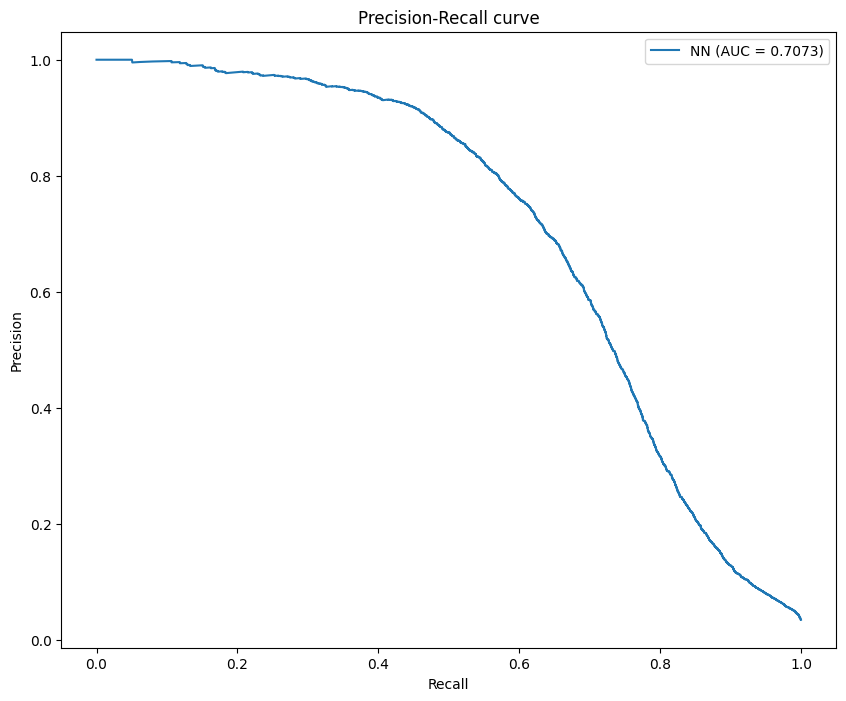

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


precision, recall, _ = precision_recall_curve(y_test, pred)

# Compute the AUC of the Precision-Recall curve
pr_auc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label=f'NN (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()

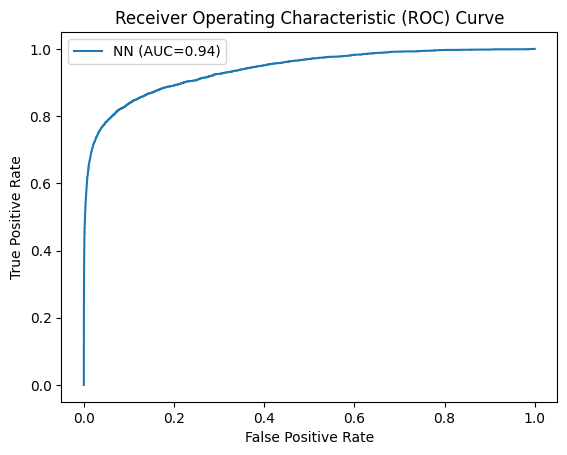

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(y_test, pred, pos_label=1)
auc_nn = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'NN (AUC={auc_nn:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred >= 0.5))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.79      0.58      0.67      4133

    accuracy                           0.98    118108
   macro avg       0.89      0.79      0.83    118108
weighted avg       0.98      0.98      0.98    118108



In [27]:
import numpy as np

np.save('fpr_nn.npy', fpr)
np.save('tpr_nn.npy', tpr)